## INTRODUCTION TO ENSEMBLE TRANSFORMATION USING PROBLY

This notebook demonstrates how to use **probly's ensemble transformation** to create uncertainty-aware machine learning models.

**What is an Ensemble?**
An *ensemble* is a group of models that learn the same task independently. By combining their predictions, we get both better predictive performance and uncertainty quantification.

**Using Probly for Ensemble Transformation:**
Probly provides a clean workflow for ensemble-based uncertainty quantification:

1. **Transform:** Use `probly.transformation.ensemble()` to create multiple independent copies of your base model
2. **Sample:** Use `probly.representation.sampling.sampler.EnsembleSampler` to collect predictions from all ensemble members
3. **Quantify:** Use `probly.quantification.classification` functions to compute uncertainty metrics from numpy arrays




In [29]:
from collections.abc import Sequence

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.optim import Adam

from probly.quantification.classification import conditional_entropy, mutual_information, total_entropy
from probly.representation.sampling.sampler import EnsembleSampler
from probly.transformation import ensemble

## DEFINE A SIMPLE MODEL AND DATA SET

In [30]:
class SimpleNN(nn.Module):
    def __init__(self) -> None:
        """Initialize a simple feedforward neural network."""
        super().__init__()
        self.fc1 = nn.Linear(2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Compute logits for the input batch."""
        x = self.relu(self.fc1(x))
        return self.fc2(x)


X, y = make_moons(n_samples=500, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


**Model Definition:**
We define a simple neural network `SimpleNN` with two fully connected layers and a ReLU activation. This is a standard `torch.nn.Module` - probly's ensemble transformation expects torch models, so we define the model using PyTorch.

**Data Preparation:**
We generate data using numpy arrays (probly's preferred format) with `make_moons()`, then convert to torch tensors only when needed for training. This follows probly's numpy-first approach where data manipulation uses numpy, and torch is only used for model operations.   



## CREATE THE ENSEMBLE AND TRAIN IT 

Here, we will call the probly ensemble transformation which takes the base model (SimpleNN) and makes 3 independent copies of it.
So now we don’t have 1 model, but rather 3 models stored together.

As for the training part, each model in the ensemble will get its own optimizer, because at this point they are training separately.
We will be training for 50 epochs (each one of them one by one) using CrossEntropyLoss.

In [ ]:
# Create base model and transform to ensemble using probly
base_model = SimpleNN()
ensemble_model = ensemble(base_model, n_members=3)


class EnsembleWrapper(nn.Module):
    def __init__(self, ensemble: Sequence[nn.Module]) -> None:
        """Wrap an ensemble of models as a single nn.Module."""
        super().__init__()
        self.ensemble = ensemble

    def forward(self, x: torch.Tensor) -> list[torch.Tensor]:
        """Forward pass that returns predictions from all ensemble members."""
        return [member(x) for member in self.ensemble]


ensemble_wrapper = EnsembleWrapper(ensemble_model)


ensemble_sampler = EnsembleSampler(ensemble_wrapper)

optimizers = [Adam(member.parameters(), lr=0.01) for member in ensemble_model]
criterion = nn.CrossEntropyLoss()
num_epochs = 50

for _epoch in range(num_epochs):
    for idx, model in enumerate(ensemble_model):
        model.train()
        optimizers[idx].zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizers[idx].step()

## EVALUATING THE ENSEMBLE

In [ ]:
for member in ensemble_model:
    member.eval()

sample = ensemble_sampler.sample(X_test_tensor)
ensemble_mean = sample.mean()

ensemble_mean_np = ensemble_mean.detach().cpu().numpy() if isinstance(ensemble_mean, torch.Tensor) else ensemble_mean

predicted = np.argmax(ensemble_mean_np, axis=1)
accuracy = (predicted == y_test).mean()
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 91.00%


**Evaluation using Probly's APIs:**

1. **Set eval mode:** Put all ensemble members in evaluation mode (no dropout, etc.)
2. **Sample predictions:** Use `probly.representation.sampling.sampler.EnsembleSampler.sample()` to collect predictions from all ensemble members. The sampler automatically aggregates them into a `Sample` object
3. **Compute mean:** Use `sample.mean()` to get the ensemble average prediction
4. **Convert to numpy:** Convert the result to numpy arrays for evaluation (probly's quantification functions work with numpy)

This demonstrates probly's workflow: use torch tensors for model operations, then convert to numpy for evaluation and uncertainty quantification. The `EnsembleSampler` handles the collection and aggregation automatically, making it easy to work with ensemble predictions.

## DECISION BOUNDARY VISUALISATION

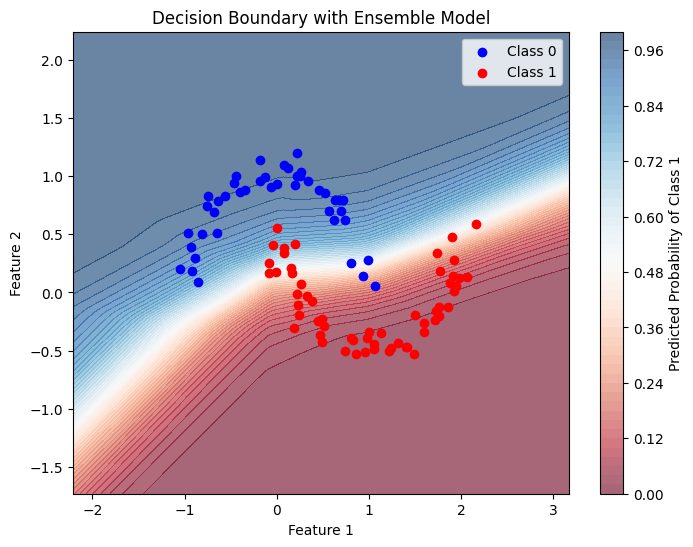

In [33]:
# Create grid for visualization using numpy (probly-friendly)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x = np.linspace(x_min, x_max, 100)
y = np.linspace(y_min, y_max, 100)
xx, yy = np.meshgrid(x, y)
grid = np.stack([xx.ravel(), yy.ravel()], axis=1)
grid_tensor = torch.tensor(grid, dtype=torch.float32)

for m in ensemble_model:
    m.eval()

with torch.no_grad():
    grid_sample = ensemble_sampler.sample(grid_tensor)
    grid_preds = grid_sample.mean()


grid_preds_np = grid_preds.detach().cpu().numpy() if isinstance(grid_preds, torch.Tensor) else grid_preds

exp_preds = np.exp(grid_preds_np - np.max(grid_preds_np, axis=1, keepdims=True))
probs = exp_preds / np.sum(exp_preds, axis=1, keepdims=True)
probs_grid = probs[:, 0].reshape(xx.shape)

plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, probs_grid, levels=50, cmap="RdBu", alpha=0.6)
plt.colorbar(label="Predicted Probability of Class 1")

plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color="blue", label="Class 0")
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color="red", label="Class 1")

plt.title("Decision Boundary with Ensemble Model")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


**Decision Boundary Visualization using Probly:**

1. **Create grid:** Generate a numpy grid covering the input space (probly's numpy-first approach)
2. **Get predictions:** Use `EnsembleSampler.sample()` to get ensemble predictions for all grid points
3. **Convert to probabilities:** Convert logits to probabilities using numpy (probly's quantification functions work with probabilities)
4. **Visualize:** Plot the decision boundary showing where the ensemble model predicts each class

The visualization shows:
- **Red/Blue regions:** Areas where the ensemble is confident about each class
- **Boundary region:** The uncertain transition zone where predictions are less certain
- **Scatter points:** Real test samples overlaid on the decision boundary

This demonstrates how probly's `EnsembleSampler` makes it easy to evaluate the ensemble across the entire input space for visualization.


## UNCERTAINTY QUANTIFICATION USING PROBLY

Now we'll use **probly's quantification functions** to compute uncertainty metrics. These functions work directly with numpy arrays of shape `(n_instances, n_samples, n_classes)`.

In [ ]:
def get_ensemble_probs(ensemble_model: Sequence[nn.Module], data: np.ndarray) -> np.ndarray:
    """Get probability predictions from all ensemble members using probly.

    Returns numpy array of shape (n_instances, n_members, n_classes) for use with
    probly's quantification functions.
    """
    for m in ensemble_model:
        m.eval()

    member_preds = []
    data_tensor = torch.tensor(data, dtype=torch.float32)

    with torch.no_grad():
        for member in ensemble_model:
            logits = member(data_tensor)
            logits_np = logits.detach().cpu().numpy() if isinstance(logits, torch.Tensor) else logits

            exp_logits = np.exp(logits_np - np.max(logits_np, axis=1, keepdims=True))
            probs = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
            member_preds.append(probs)

    return np.stack(member_preds, axis=1)


def tu(probs: np.ndarray) -> np.ndarray:
    """Total Uncertainty using probly's total_entropy."""
    return total_entropy(probs)


def au(probs: np.ndarray) -> np.ndarray:
    """Aleatoric Uncertainty using probly's conditional_entropy."""
    return conditional_entropy(probs)


def eu(probs: np.ndarray) -> np.ndarray:
    """Epistemic Uncertainty using probly's mutual_information."""
    return mutual_information(probs)

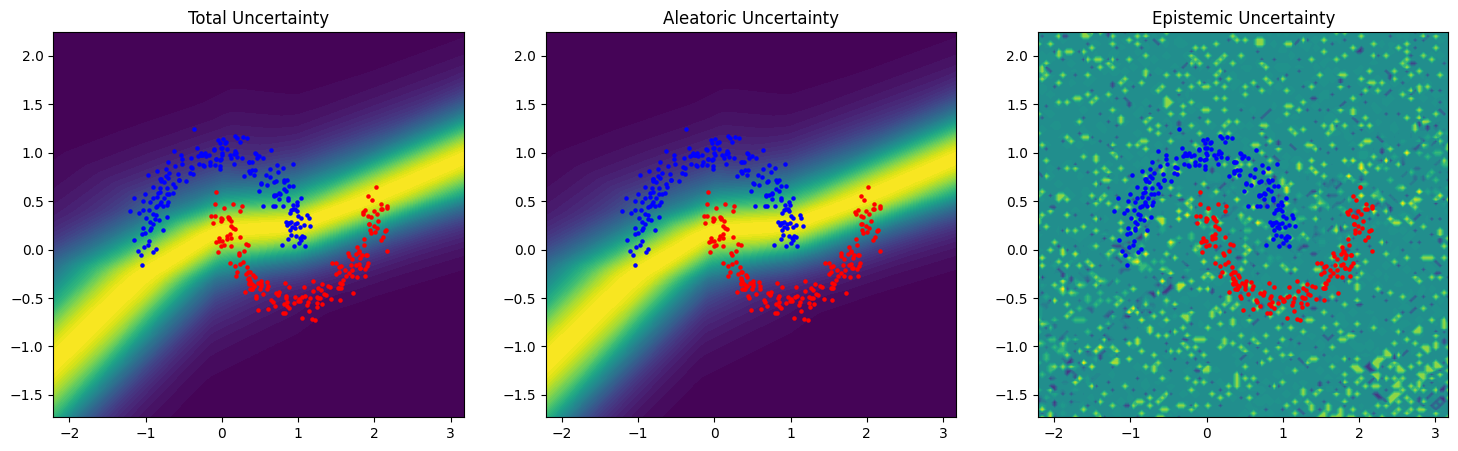

In [ ]:
grid_probs = get_ensemble_probs(ensemble_model, grid)

# Compute uncertainty metrics using probly's quantification functions
tu_values = tu(grid_probs)  # Total Uncertainty
au_values = au(grid_probs)  # Aleatoric Uncertainty
eu_values = eu(grid_probs)  # Epistemic Uncertainty


tu_grid = tu_values.reshape(xx.shape)
au_grid = au_values.reshape(xx.shape)
eu_grid = eu_values.reshape(xx.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].contourf(xx, yy, tu_grid, levels=50, cmap="viridis")
axes[0].set_title("Total Uncertainty")

axes[1].contourf(xx, yy, au_grid, levels=50, cmap="viridis")
axes[1].set_title("Aleatoric Uncertainty")

axes[2].contourf(xx, yy, eu_grid, levels=50, cmap="viridis")
axes[2].set_title("Epistemic Uncertainty")

for ax in axes:
    ax.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c="blue", s=5, zorder=5)
    ax.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c="red", s=5, zorder=5)

plt.show()

### Uncertainty Visualization

Here, we compute three types of uncertainty metrics for every point in the grid:
- **Total Uncertainty (TU):** overall uncertainty in the model’s predictions.  
- **Aleatoric Uncertainty (AU):** uncertainty caused by noise or overlap in the data itself.  
- **Epistemic Uncertainty (EU):** uncertainty that comes from limited knowledge or model disagreement.

By plotting these values, we can see which regions of the input space are more uncertain.  
High epistemic uncertainty usually appears in areas far from the training data, while high aleatoric uncertainty occurs where the two classes overlap.  
These visualizations demonstrate how the probly ensemble transformation adds uncertainty awareness to an otherwise deterministic neural network.


## SUMMARY: USING ENSEMBLE TRANSFORMATION WITH PROBLY

This notebook demonstrates the **workflow** for using probly's ensemble transformation:

### The Probly Ensemble Workflow:

1. **Model Definition:** Define your base model as a `torch.nn.Module` (probly expects torch models)

2. **Ensemble Creation:** Use `probly.transformation.ensemble(base_model, n_members=3)` to create multiple independent copies with different initializations

3. **Wrapper Creation:** Create an `EnsembleWrapper` that returns predictions from all members as an iterable - this is required for `EnsembleSampler`

4. **Sampler Setup:** Use `probly.representation.sampling.sampler.EnsembleSampler(ensemble_wrapper)` to create a sampler that aggregates predictions

5. **Training:** Train each ensemble member independently using standard PyTorch (torch tensors and optimizers)

6. **Prediction:** Use `ensemble_sampler.sample(data)` to collect predictions from all members, which returns a `Sample` object with `.mean()` method

7. **Uncertainty Quantification:** Use probly's quantification functions on numpy arrays:
   - `probly.quantification.classification.total_entropy()` for total uncertainty
   - `probly.quantification.classification.conditional_entropy()` for aleatoric uncertainty  
   - `probly.quantification.classification.mutual_information()` for epistemic uncertainty


